# Introduction

Notebook to aggregate the running of models in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import similarity_measures as sm

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle = fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)


### Results

In [4]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Grouping Results by Model

#### Function to Return Trace_Links_DF

In [5]:
def get_trace_links_df(model, perc_precision="", perc_recall=""):
    if perc_precision != "":
        df = evals_df_4[(evals_df_4.model == model) & (evals_df_4.perc_precision == perc_precision)]
        return df.iloc[-1,:].trace_links_df
    elif perc_recall != "":
        df = evals_df_4[(evals_df_4.model == model) & (evals_df_4.perc_recall == perc_recall)]
        return df.iloc[-1,:].trace_links_df

#### Min Precision

In [6]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

model
bm25          11.65
lda            3.66
lsi           12.53
wordvector     9.67
Name: perc_precision, dtype: float64


#### Lists of Results

In [7]:
bm25_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='bm25', perc_precision=bm25_min_prec))
bm25_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='bm25', perc_precision=bm25_min_prec))
bm25_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='bm25', perc_precision=bm25_min_prec))

lsi_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lsi', perc_precision=lsi_min_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lsi', perc_precision=lsi_min_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lsi', perc_precision=lsi_min_prec))

lda_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lda', perc_precision=lda_min_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lda', perc_precision=lda_min_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lda', perc_precision=lda_min_prec))

wv_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='wordvector', perc_precision=wv_min_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='wordvector', perc_precision=wv_min_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='wordvector', perc_precision=wv_min_prec))

##### BM25 vs LSI vs LDA

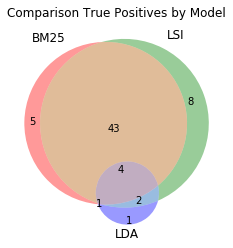

In [12]:
venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model')
plt.show()

##### BM25 vs WV vs LDA

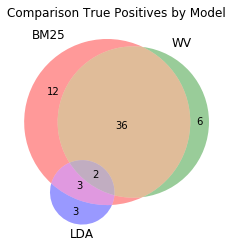

In [9]:
venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model')
plt.show()

##### LSI vs WV vs LDA

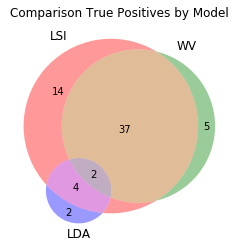

In [14]:
venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model')
plt.show()

In [15]:
bm25_tp_set - lsi_tp_set

{('apz_async_scrolling', 1287687),
 ('apz_async_scrolling', 1295502),
 ('downloads_dropmaker', 1432915),
 ('flac_support', 1335538),
 ('new_awesome_bar', 1451475),
 ('pointer_lock_api', 1314643)}

In [16]:
lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set

{('browser_customization', 1449700)}

In [17]:
wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set

{('browser_customization', 1279140),
 ('indicator_device_perm', 1357458),
 ('indicator_device_perm', 1430603)}

In [ ]:
for idx,col in fp_list:
    print('Feature: {:<24} <=> BR: {:>8} : {:>50}'.format(idx, col, str(bugreports[bugreports.Bug_Number == col].Summary.values[0])))

#### Min Recall

In [19]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

model
bm25          23.43
lda            5.49
lsi           13.32
wordvector    10.44
Name: perc_recall, dtype: float64


#### Lists of Results

In [32]:
bm25_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='bm25', perc_recall=bm25_min_recall))
bm25_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='bm25', perc_recall=bm25_min_recall))
bm25_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='bm25', perc_recall=bm25_min_recall))

lsi_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lsi', perc_recall=lsi_min_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lsi', perc_recall=lsi_min_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lsi', perc_recall=lsi_min_recall))

lda_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lda', perc_recall=lda_min_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lda', perc_recall=lda_min_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lda', perc_recall=lda_min_recall))

wv_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='wordvector', perc_recall=wv_min_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='wordvector', perc_recall=wv_min_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='wordvector', perc_recall=wv_min_recall))

##### BM25 vs LSI vs LDA

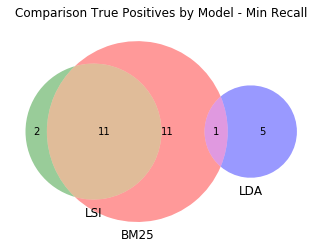

In [33]:
venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model - Min Recall')
plt.show()

##### BM25 vs WV vs LDA

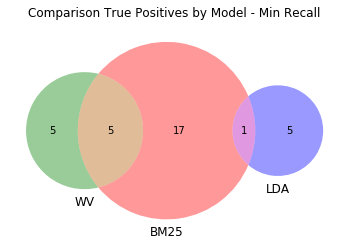

In [34]:
venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model - Min Recall')
plt.show()

##### LSI vs WV vs LDA

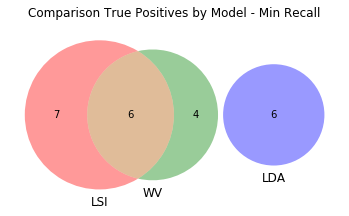

In [35]:
venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model - Min Recall')
plt.show()

In [36]:
lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set

set()

In [37]:
bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set

{('context_menu', 1270983),
 ('context_menu', 1313969),
 ('indicator_device_perm', 1296861),
 ('new_awesome_bar', 1276120),
 ('new_awesome_bar', 1291770),
 ('new_awesome_bar', 1297976),
 ('new_awesome_bar', 1309856),
 ('new_awesome_bar', 1311998),
 ('new_awesome_bar', 1339497),
 ('new_awesome_bar', 1357458)}

In [38]:
lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set

{('browser_customization', 1301784),
 ('browser_customization', 1344446),
 ('browser_customization', 1353831),
 ('browser_customization', 1449700),
 ('browser_customization', 1451475)}

In [39]:
wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set

{('new_awesome_bar', 1296366),
 ('new_awesome_bar', 1352539),
 ('new_awesome_bar', 1353831)}

#### Max Precision

In [41]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

model
bm25          25.27
lda           14.29
lsi           31.32
wordvector    28.57
Name: perc_precision, dtype: float64


#### Lists of Results

In [50]:
bm25_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='bm25', perc_precision=bm25_max_prec))
bm25_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='bm25', perc_precision=bm25_max_prec))
bm25_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='bm25', perc_precision=bm25_max_prec))

lsi_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lsi', perc_precision=lsi_max_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lsi', perc_precision=lsi_max_prec))
lsi_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lsi', perc_precision=lsi_max_prec))

lda_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lda', perc_precision=lda_max_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lda', perc_precision=lda_max_prec))
lda_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lda', perc_precision=lda_max_prec))

wv_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='wordvector', perc_precision=wv_max_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='wordvector', perc_precision=wv_max_prec))
wv_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='wordvector', perc_precision=wv_max_prec))

##### BM25 vs LSI vs LDA

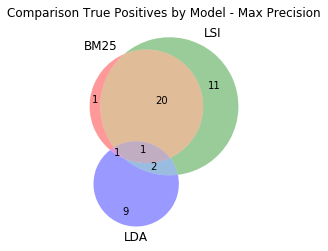

In [51]:
venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model - Max Precision')
plt.show()

##### BM25 vs WV vs LDA

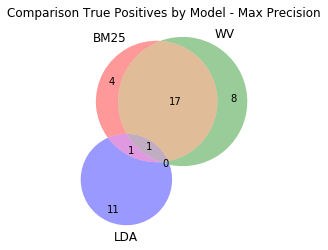

In [52]:
venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model - Max Precision')
plt.show()

##### LSI vs WV vs LDA

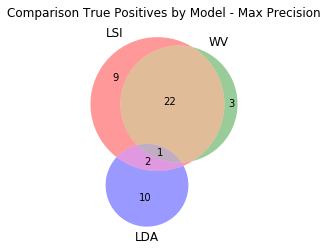

In [53]:
venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model - Max Precision')
plt.show()

In [54]:
lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set

{('downloads_dropmaker', 1292573),
 ('indicator_device_perm', 1345687),
 ('new_awesome_bar', 1408361),
 ('pdf_viewer', 1301056),
 ('zoom_indicator', 1305195)}

In [55]:
bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set

set()

In [56]:
lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set

{('browser_customization', 1248268),
 ('browser_customization', 1279140),
 ('browser_customization', 1301784),
 ('browser_customization', 1313290),
 ('browser_customization', 1318903),
 ('browser_customization', 1336227),
 ('browser_customization', 1344446),
 ('browser_customization', 1357458),
 ('browser_customization', 1449700)}

In [57]:
wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set

{('new_awesome_bar', 1352539), ('new_awesome_bar', 1451475)}

#### Max Recall

In [58]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

model
bm25          48.22
lda           48.41
lsi           52.06
wordvector    41.13
Name: perc_recall, dtype: float64


#### Lists of Results

In [59]:
bm25_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='bm25', perc_recall=bm25_max_recall))
bm25_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='bm25', perc_recall=bm25_max_recall))
bm25_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='bm25', perc_recall=bm25_max_recall))

lsi_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lsi', perc_recall=lsi_max_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lsi', perc_recall=lsi_max_recall))
lsi_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lsi', perc_recall=lsi_max_recall))

lda_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='lda', perc_recall=lda_max_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='lda', perc_recall=lda_max_recall))
lda_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='lda', perc_recall=lda_max_recall))

wv_tp_set = aux_functions.get_true_positives( oracle, get_trace_links_df(model='wordvector', perc_recall=wv_max_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, get_trace_links_df(model='wordvector', perc_recall=wv_max_recall))
wv_fn_set = aux_functions.get_false_negatives(oracle, get_trace_links_df(model='wordvector', perc_recall=wv_max_recall))

##### BM25 vs LSI vs LDA

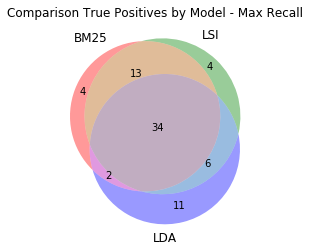

In [60]:
venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model - Max Recall')
plt.show()

##### BM25 vs WV vs LDA

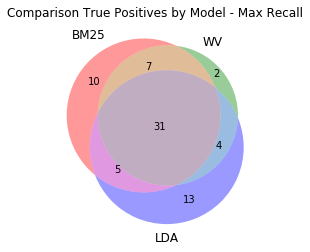

In [61]:
venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model - Max Recall')
plt.show()

##### LSI vs WV vs LDA

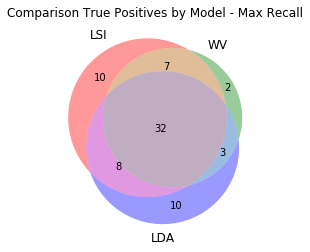

In [62]:
venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model - Max Recall')
plt.show()

In [63]:
lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set

{('pdf_viewer', 1301056), ('pdf_viewer', 1365887), ('tts_in_rm', 1335538)}

In [64]:
bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set

{('apz_async_scrolling', 1295502),
 ('flac_support', 1335538),
 ('pointer_lock_api', 1314643)}

In [65]:
lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set

{('browser_customization', 1248268),
 ('browser_customization', 1313290),
 ('browser_customization', 1336227),
 ('browser_customization', 1449700),
 ('indicator_device_perm', 1290424),
 ('new_awesome_bar', 1278388),
 ('new_awesome_bar', 1313778),
 ('webgl_comp', 1312018),
 ('webgl_comp', 1365887)}

In [66]:
wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set

{('indicator_device_perm', 1430603)}

### Plots

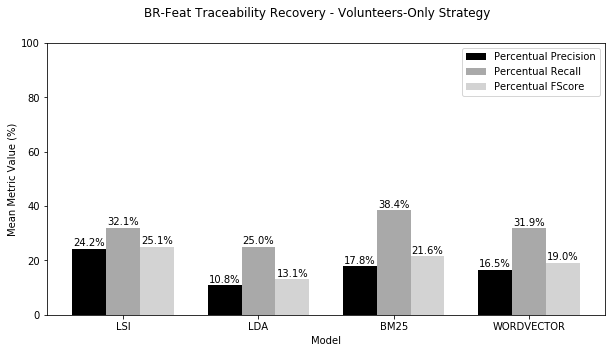

In [11]:
evaluator_4.plot_evaluations_3(evals_df_4, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

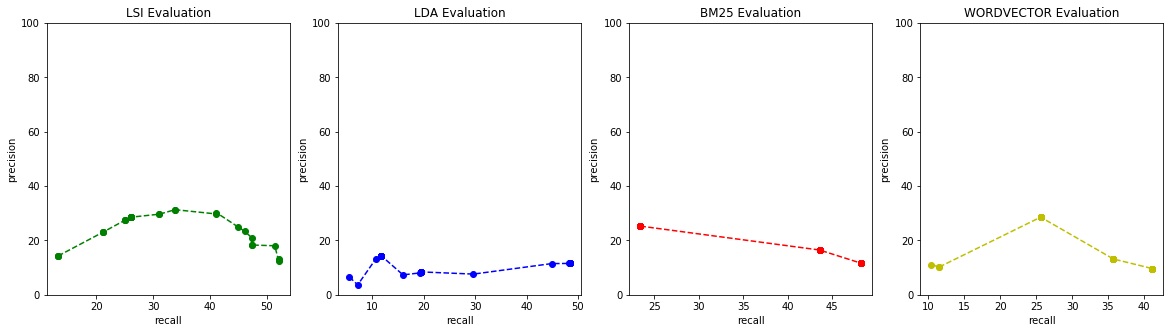

In [12]:
evaluator_4.plot_evaluations_4(evals_df_4)

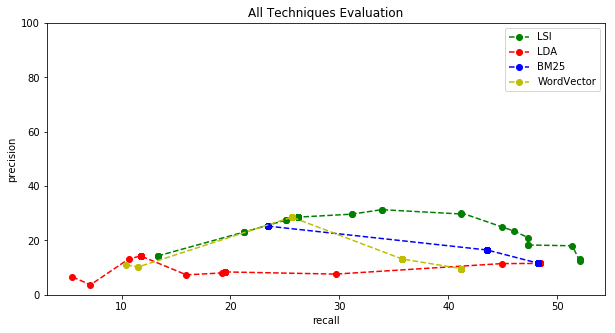

In [13]:
evaluator_4.plot_evaluations_5(evals_df_4)

### Delete Variables

## Union Strategy

In [ ]:
models_runner_1 = Feat_BR_Models_Runner()
lsi_model_1 = models_runner_1.run_lsi_model()
lda_model_1 = models_runner_1.run_lda_model()
bm25_model_1 = models_runner_1.run_bm25_model()
w2v_model_1 = models_runner_1.run_word2vec_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)
evals_df_1 = evaluator_1.run_evaluator(models=[lsi_model_1,lda_model_1,bm25_model_1,w2v_model_1], 
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

### Results

In [ ]:
evals_df_1.head()

In [ ]:
evaluator_1.plot_evaluations_4(evals_df_1)

In [ ]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Plots

In [ ]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

### Delete Variables

## Intersec Strategy

In [ ]:
models_runner_2 = Feat_BR_Models_Runner()
lsi_model_2 = models_runner_2.run_lsi_model()
lda_model_2 = models_runner_2.run_lda_model()
bm25_model_2 = models_runner_2.run_bm25_model()
w2v_model_2 = models_runner_2.run_word2vec_model()

evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)
evals_df_2 = evaluator_2.run_evaluator(models=[lsi_model_2,lda_model_2, bm25_model_2, w2v_model_2],
                                      top_values=[1,3,5,10], 
                                      sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

### Results

In [ ]:
evals_df_2.head()

### Plots

In [ ]:
evaluator_2.plot_evaluations_3(evals_df_2, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

In [ ]:
evaluator_2.plot_evaluations_4(evals_df_2)

In [ ]:
evaluator_2.plot_evaluations_5(evals_df_2)

### Delete Variables

## Expert Only Strategy

In [ ]:
models_runner_3 = Feat_BR_Models_Runner()
lsi_model_3 = models_runner_3.run_lsi_model()
lda_model_3 = models_runner_3.run_lda_model()
bm25_model_3 = models_runner_3.run_bm25_model()
w2v_model_3 = models_runner_3.run_word2vec_model()

evaluator_3 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)
evals_df_3 = evaluator_3.run_evaluator(models=[lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

### Results

In [ ]:
evals_df_3.head()

### Plots

In [ ]:
evaluator_3.plot_evaluations_3(evals_df_3, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

In [ ]:
evaluator_3.plot_evaluations_4(evals_df_3)

In [ ]:
evaluator_3.plot_evaluations_5(evals_df_3)

### Delete Variables

del lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3
del evals_df_3
del models_runner_3, evaluator_3